In [38]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

2586.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2593.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2600.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2607.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import os
import io
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [11]:
from typing import List

class JsonFile:
    def __init__(self, path: str):
        self.handles = []
        if os.path.isdir(path):
            self.path = os.path.abspath(path)
            self.file = None
            self.is_file = False
        elif os.path.isfile(path):
            path, tail = os.path.split(path)
            self.path = os.path.abspath(path)
            self.file = tail
            self.is_file = True
        else:
            self.path = os.path.abspath('./')
            self.file = path if path.endswith(".json") else f"{path}.json"
            self.is_file = True

    def __del__(self):
        self.close()

    def parent(self):
        return JsonFile(self.path if self.is_file else os.path.parent(self.path))

    def name(self) -> str:
        return self.name

    def post_fix_notation(self) -> str:
        return f"{self.name}_" if self.is_file else ""

    def sibling(self, name: str, post_fix: bool = False):
        name = f"{self.post_fix_notation()}{name}" if post_fix else name
        return JsonFile(os.path.join(self.path, name))

    def full_path(self) -> str:
        return os.path.join(self.path, self.file) if self.is_file else self.path

    def open(self, mode: str, save_handle: bool = True) -> io.TextIOWrapper:
        if self.is_file:
            handle = open(self.full_path(), mode, encoding='utf8')
            if save_handle:
                self.handles.append(handle)

            return handle
        else:
            return None

    def close(self):
        for handle in self.handles:
            if not handle.closed:
                handle.clos()

        self.handles.clear()


    def save(self, obj: object):
        with self.open('wt', False) as handle:
            if handle:
                json.dump(obj, handle, indent=2)
    
    def load(self) -> object:
        with self.open('rt', False) as handle:
            if handle:
                return json.load(handle)
            else:
                return None

    def delete(self):
        if self.is_file:
            os.remove(self.full_path())
        else:
            os.rmdir(self.full_path())

    def load_df(self, orient: str = 'record') -> pd.DataFrame:
        return pd.read_json(self.full_path(), orient=orient)


def dump_json(**kwargs):
    for key, value in kwargs.items():
        with open(f"{key}.json", 'wt', encoding='utf8') as outfile:
            json.dump(value, outfile, indent=2)

def load_json_files(*args):
    for file in args:
        yield JsonFile(file)

def load_json_df(*args, **kwargs):
    for file in args:
        yield pd.read_json(f"{file}.json", orient='record')

    for file, orient in kwargs.items():
        yield pd.read_json(f"{file}.json", orient=orient)

def siblings(files: List[JsonFile], name: str, post_fix: bool = False) -> List[JsonFile]:
    for file in files:
        yield file.sibling(name, post_fix)

In [12]:
files_raw = list(load_json_files("evaluation_results/baseline-blind/predictions_basemodel_blind_evaluation.json", "evaluation_results/baseline-tags/predictions_basemodel_tags_evaluation.json", "evaluation_results/finetuned/predictions_basemodel_finetune_evaluation.json"))
files = []


def filter_predictions(files = List[JsonFile]): List[JsonFile]
for raw in tqdm(files_raw):
    songs = raw.load()
    songs = list(filter(lambda x: 'RawPrediction' in x, songs))
    sibling = raw.sibling('predictions')
    files.append(sibling)
    sibling.save(songs)

    

100%|██████████| 3/3 [00:00<00:00,  5.28it/s]


In [37]:
def unfuck(prediction):
    fucked_index = prediction.find("}")
    if fucked_index >= 0:
        try:
            json_data = json.loads(prediction[0:fucked_index+1])
            unfucked_tags = json_data['tags']
            return False, unfucked_tags
        except Exception as fuckedup:
            return True, None
    else:
        return True, None
    
    return fucked

song_ids = []
with open('data/all_songs.json', 'rt', encoding='utf8') as infile:
    songs = json.load(infile)
    for song in songs:
        song_ids.append(song['GeniusId'])

with open('predictions_evaluation.json', 'rt', encoding='utf8') as infile:
    unfucked_songs = []
    songs = json.load(infile) 
    songs_len = len(songs)
    for song in tqdm(songs, total=songs_len):
        if(song['GeniusId'] in song_ids or not song['Lyrics']):
            continue

        if('PredictedTags' not in song or song['PredictedTags'] == None):
            song['WasFucked'] = True
            is_fucked, tags = unfuck(song['RawPrediction'])
            if is_fucked:
                song['IsFucked'] = True 
            else:
                song['IsFucked'] = False
                song['PredictedTags'] = tags
        else:
            song['WasFucked'] = True
            song['IsFucked'] = False
        
        unfucked_songs.append(song)

    with open('predictions_evaluation_unfucked.json', 'wt', encoding='utf8') as outfile:
        json.dump(unfucked_songs, outfile, indent=2)

100%|██████████| 25000/25000 [00:09<00:00, 2655.66it/s]


In [9]:
tag_alias = json.load(open('tag_alias.json'))
tag_lookup = {alias: tag for tag, aliases in tag_alias.items() for alias in aliases}
print(tag_lookup)

with open('predictions_evaluation_unfucked.json', 'rt', encoding='utf8') as infile:
    songs = json.load(infile)
    for song in tqdm(songs):
        song['LastFMTags'] = list(set([tag_lookup[x] if x in tag_lookup else x for x in song['LastFMTags']]))
        song['PredictedTags'] = list(set([tag_lookup[x] if x in tag_lookup else x for x in song ['PredictedTags']]))

    with open('predictions_evaluation_unfucked_cleaned-tags.json', 'wt', encoding='utf8') as outfile:
        json.dump(songs, outfile, indent=2)

{'pop': 'pop', 'pop music': 'pop', 'azerbaijan': 'azerbaijan', 'azeri': 'azerbaijan', 'dominican republic': 'dominican', 'dominican': 'dominican', 'deutsch': 'german', 'german': 'german', 'german lyrics': 'german', 'melancholy': 'melancholic', 'melancholic': 'melancholic', '-melancholic-': 'melancholic', 'melancolica': 'melancholic', 'indie india': 'idian-indie', 'indian indie': 'idian-indie', 'christmas': 'christmas', 'xmas': 'christmas', 'christmas tag': 'christmas', 'nepal': 'nepal', 'nepali': 'nepal', 'folk pop': 'folk pop', 'pop-folk': 'folk pop', 'folkpop': 'folk pop', 'colombia': 'colombia', 'colombian': 'colombia', 'r and b': 'rhythm and blues', 'r&amp;b': 'rhythm and blues', 'rhythm and blues': 'rhythm and blues', 'rb': 'rhythm and blues', 'rnb': 'rhythm and blues', 'brasil': 'brasil', 'brazilian': 'brasil', 'brazil': 'brasil', 'pop-rap': 'pop rap', 'pop rap': 'pop rap', 'death metal': 'death metal', '-death metal-': 'death metal', 'trash metal': 'thrash metal', 'thrash metal'

100%|██████████| 23256/23256 [00:00<00:00, 277678.02it/s]


In [10]:
tag_alias = json.load(open('tag_alias.json'))  
tags = pd.read_csv('tags_manual_removal.csv', index_col='Tag')
curated_tags = list(set([tag_lookup[x] if x in tag_lookup else x for x, _ in tags.iterrows()]))
with open('curated_tags.json', 'wt', encoding='utf8') as outfile:
    json.dump(curated_tags, outfile, indent=2)

In [11]:
curated_tags = json.load(open('curated_tags.json'))
data = pd.read_json('predictions_evaluation_unfucked_cleaned-tags.json', orient='records')
data.set_index('GeniusId', inplace=True)
data.info()

def get_counts(name):
    tag_counts = data[name].explode().value_counts().reset_index()
    tag_counts.columns = ['Tag', 'Count']
    tag_counts.set_index('Tag', inplace=True)
    tag_counts = tag_counts.loc[tag_counts.index.intersection(curated_tags)]
    tag_counts.info()
    return tag_counts


get_counts('LastFMTags').to_csv('tag_counts_actual.csv')
get_counts('PredictedTags').to_csv('tag_counts_predicted.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 23256 entries, 1046647 to 1821834
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ArtistId           23256 non-null  int64 
 1   PrimaryArtistName  23256 non-null  object
 2   FeaturedArtists    23256 non-null  object
 3   Title              23256 non-null  object
 4   Lyrics             23256 non-null  object
 5   ArtistNames        23256 non-null  object
 6   HasCompleteLyrics  23256 non-null  bool  
 7   LastFMTags         23256 non-null  object
 8   RawPrediction      23256 non-null  object
 9   PredictedTags      23256 non-null  object
 10  WasFucked          23256 non-null  bool  
 11  IsFucked           23256 non-null  bool  
dtypes: bool(3), int64(1), object(8)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 430 entries, hip-hop to trap rap
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  -------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


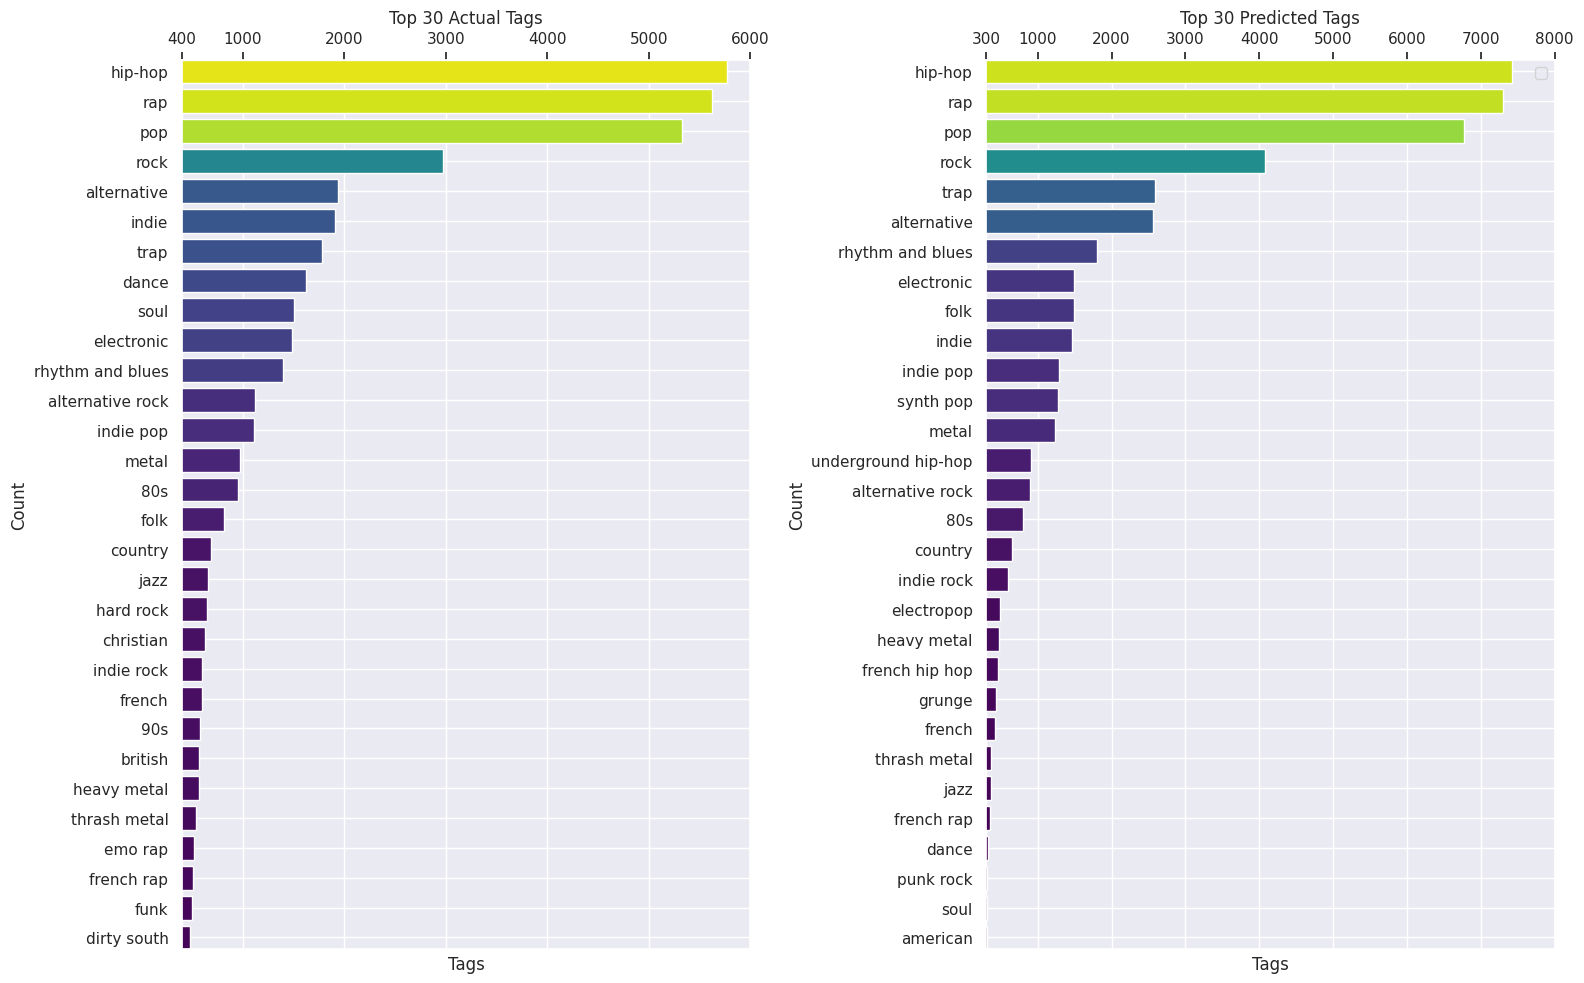

In [12]:
sns.set_theme(style='whitegrid')
sns.set_color_codes('pastel')
sns.set()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(16)

def render_counts(title, tags, ax, top_n):
    cmap = plt.get_cmap('viridis')
    to_show = tags.sort_values(by=['Count'], ascending=False).head(top_n).sort_values(by=['Count'], ascending=True)
    rounded_max = (np.ceil(to_show.Count.max() / 1000) * 1000)
    rounded_min = (np.floor(to_show.Count.min() / 100) * 100)
    rounded_min_thousand = (np.ceil(to_show.Count.min() / 1000) * 1000)

    rescale = lambda y: (y - rounded_min) / (rounded_max - rounded_min)
    ax.barh(to_show.index, to_show['Count'], color=cmap(rescale(to_show.Count)))
    ax.set_title(f'Top {top_n} {title}')
    ax.set_xlabel('Tags')
    ax.set_ylabel('Count')
    ax.set_xlim(rounded_min, rounded_max)

    ticks = np.arange(rounded_min_thousand, rounded_max + 1, 1000)
    ticks = np.insert(ticks, 0, rounded_min)

    ax.set_xticks(ticks)
    ax.xaxis.tick_top()
    ax.margins(0,0)


tags_actual = pd.read_csv('tag_counts_actual.csv', index_col='Tag')
tags_predicted = pd.read_csv('tag_counts_predicted.csv', index_col='Tag')
render_counts('Actual Tags', tags_actual, ax1, 30)
render_counts('Predicted Tags', tags_predicted, ax2, 30)

plt.tight_layout()
plt.legend()
plt.show()

In [21]:
curated_tags = json.load(open('curated_tags.json'))
songs = pd.read_json('predictions_evaluation_unfucked_cleaned-tags.json', orient='records')
songs.set_index('GeniusId', inplace=True)

true_positives = {x: {'count': 0} for x in curated_tags}
false_positives = {x: {'count': 0, 'songs': []} for x in curated_tags}
true_negatives = {x: {'count': 0} for x in curated_tags}
false_negatives = {x: {'count': 0, 'songs': []} for x in curated_tags}

matrix = {
    'TrueNegatives': true_negatives,
    'TruePositives': true_positives,
    'FalseNegatives': false_negatives,
    'FalsePositives': false_positives
}

for idx, song in tqdm(songs.iterrows(), total=len(songs)):
    actual_tags = [x for x in song['LastFMTags'] if x in curated_tags]
    predicted_tags = [x for x in song['PredictedTags'] if x in curated_tags]
    for tag in curated_tags:
        if tag in actual_tags and tag in predicted_tags:
            true_positives[tag]['count'] = true_positives[tag]['count'] + 1
        elif tag in actual_tags and tag not in predicted_tags:
            false_negatives[tag]['count'] = false_negatives[tag]['count'] + 1
            false_negatives[tag]['songs'].append(idx)
        elif tag not in actual_tags and tag in predicted_tags:
            false_positives[tag]['count'] = false_positives[tag]['count'] + 1
            false_positives[tag]['songs'].append(idx)
        else:
            true_negatives[tag]['count'] = true_negatives[tag]['count'] + 1


with open('confusion_matrix.json', 'wt', encoding='utf8') as outfile:
    json.dump(matrix, outfile, indent=2)

matrix_per_tag = {x: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0, 'FP_songs': [], 'FN_songs': []} for x in curated_tags}

def rate_to_tag(rate, prop, songs):
    for tag, rate in tqdm(rate.items()):
        matrix_per_tag[tag][prop] = rate['count']
        if songs:
            matrix_per_tag[tag][f"{prop}_songs"].extend(rate['songs'])


rate_to_tag(true_positives, 'TP', False)
rate_to_tag(true_negatives, 'TN', False)
rate_to_tag(false_negatives, 'FN', False)
rate_to_tag(false_positives, 'FP', False)

counts_actual = pd.read_csv('tag_counts_actual.csv', index_col='Tag')
counts_predicted = pd.read_csv('tag_counts_predicted.csv', index_col='Tag')

total = len(songs)
confusion_matrix_record_like = []
for tag, data in matrix_per_tag.items():
    data['Accuracy'] = float(data['TP'] + data['TN']) / total 
    data['Precision'] = 1.0 if data['TP'] + data['FP'] == 0 else data['TP'] / float(data['TP'] + data['FP'])
    data['Recall'] = data['TP'] / float(data['TP'] + data['FN'])
    data['F1'] = 2.0*data['TP'] / (2*(data['TP'] + data['FP'] + data['FN']))
    data['Specificity'] = data['TN'] / float(data['TN'] + data['FP'])
    data = data.copy()
    data['Tag'] = tag
    data['ActualCount'] = int(counts_actual.loc[tag].Count)
    data['PredictedCount'] = int(counts_predicted.loc[tag].Count if tag in counts_predicted.index else 0)
    confusion_matrix_record_like.append(data)


with open('confusion_matrix_index.json', 'wt', encoding='utf8') as outfile:
    json.dump(matrix_per_tag, outfile, indent=2)

with open('confusion_matrix_record.json', 'wt', encoding='utf8') as outfile:
    json.dump(confusion_matrix_record_like, outfile, indent=2)


100%|██████████| 430/430 [00:00<00:00, 2550991.12it/s]


/tmp/ipykernel_2273364/1632560987.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  confusion_percentage_tags = confusion_percentage.applymap(lambda x: f"{x:.1f}%")


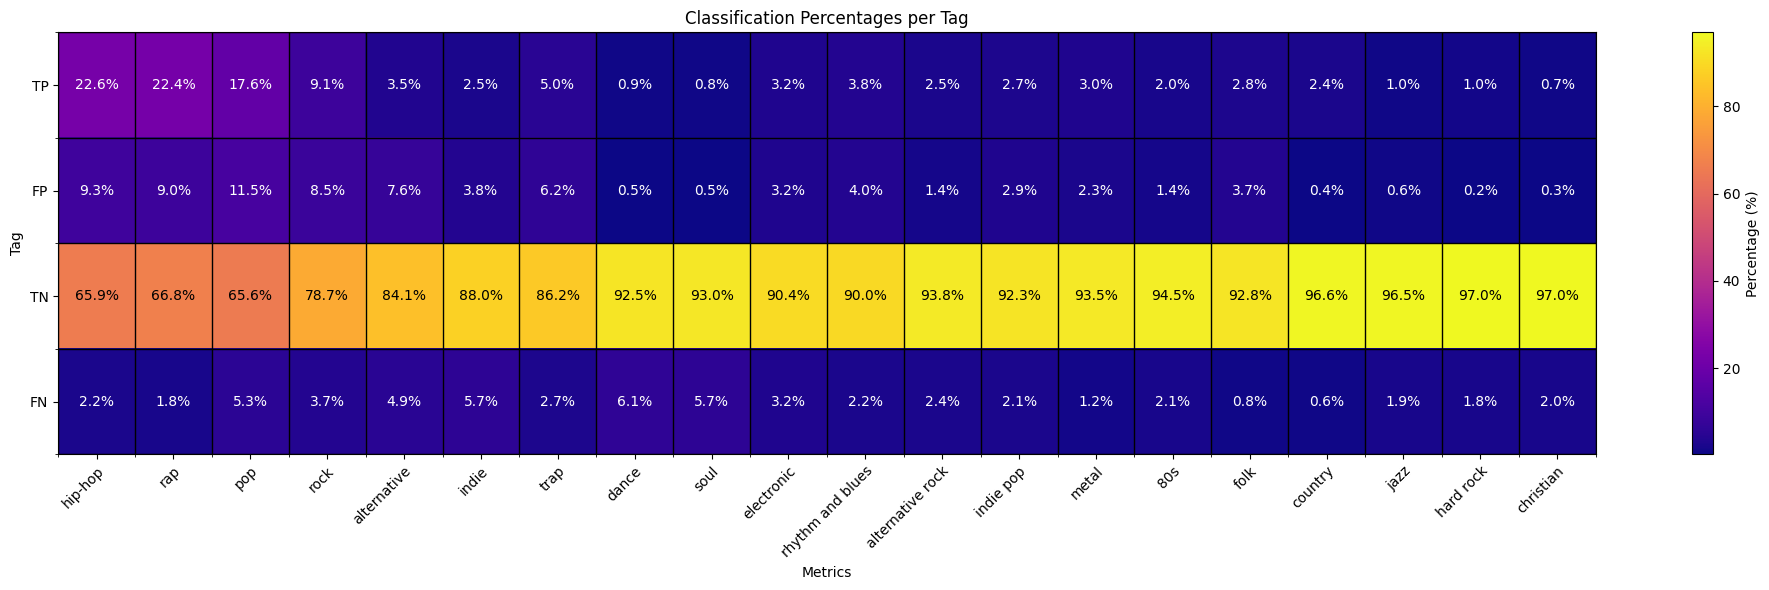

In [19]:
confusion = pd.read_json('confusion_matrix_index.json', orient='index')
tag_counts_actual = pd.read_csv('tag_counts_actual.csv', index_col='Tag')
confusion.drop(columns=['FN_songs', 'FP_songs', 'Accuracy', 'Specificity', 'F1', 'Precision', 'Recall'], inplace=True)

sns.reset_orig()

top_n = 20
to_show = [x for x, _ in tag_counts_actual.sort_values(by=['Count'], ascending=False).head(top_n).iterrows()]
confusion_transposed = confusion.loc[to_show].T
confusion_percentage = confusion_transposed.div(confusion_transposed.sum()).mul(100)
confusion_percentage_tags = confusion_percentage.applymap(lambda x: f"{x:.1f}%")

df_percent = confusion_percentage
data_array = df_percent.values

# Plotting with plt.imshow
fig, ax = plt.subplots(figsize=(20, 6))
cax = ax.imshow(data_array, cmap="plasma", aspect="auto")

# Adding color bar
fig.colorbar(cax, label='Percentage (%)')

# Setting labels for columns and rows
ax.set_xticks(np.arange(len(df_percent.columns)))
ax.set_yticks(np.arange(len(df_percent.index)))
ax.set_xticklabels(df_percent.columns)
ax.set_yticklabels(df_percent.index)

ax.set_xticks(np.arange(data_array.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data_array.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
threshold = data_array.max() / 2  # Typically mid point is used, adjust as needed

# Adding text annotations
for i in range(len(df_percent.index)):
    for j in range(len(df_percent.columns)):
        color = 'white' if data_array[i, j] < threshold else 'black'
        text = ax.text(j, i, f"{data_array[i, j]:.1f}%", ha="center", va="center", color=color)

ax.set_title("Classification Percentages per Tag")
plt.xlabel("Metrics")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()

In [54]:
confusion_data = pd.read_json('confusion_matrix_record.json', orient='record')
confusion_data.set_index('Tag', inplace=True)

def calc_confusion_scores(data, name):
    tp = int(data.TP.sum())
    fp = int(data.FP.sum())
    tn = int(data.TN.sum())
    fn = int(data.FN.sum())

    total = float(sum([tp, fp, tn, fn]))
    tp_p = tp / total
    fp_p = fp / total
    tn_p = tn / total
    fn_p = fn / total

    accuracy = (tp + tn) / total
    precision = tp / float(tp + fp)
    recall = tp / float(tp + fn)
    f1 = 2*tp / float(2*tp + fp + fn)
    specificity = tn / float(tn + fp)
    return { 'Name': name, 'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn, 'Total': int(total), 'TP_P': tp_p, 'FP_P': fp_p, 'TN_P': tn_p, 'FN_P': fn_p, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'Specificity': specificity }


confusion_all = calc_confusion_scores(confusion_data, "All")
confusion_over_250 = calc_confusion_scores(confusion_data[confusion_data['ActualCount'] >= 250], "Count ≥ 250")
confusion_over_500 = calc_confusion_scores(confusion_data[confusion_data['ActualCount'] >= 500], "Count ≥ 500")
confusion_top_20 = calc_confusion_scores(confusion_data.sort_values(by=['ActualCount'], ascending=False).head(20), "Top 20")

confusion_records = [confusion_all, confusion_over_250, confusion_over_500, confusion_top_20]
dump_json(confusion_records=confusion_records, confusion_all=confusion_all, confusion_over_250=confusion_over_250, confusion_over_500=confusion_over_500, confusion_top_20=confusion_top_20)
confusion_data = pd.read_json('confusion_matrix_record.json', orient='record')
confusion_data.set_index('Tag', inplace=True)

def calc_confusion_scores(data, name):
    tp = int(data.TP.sum())
    fp = int(data.FP.sum())
    tn = int(data.TN.sum())
    fn = int(data.FN.sum())

    total = float(sum([tp, fp, tn, fn]))
    tp_p = tp / total
    fp_p = fp / total
    tn_p = tn / total
    fn_p = fn / total

    accuracy = (tp + tn) / total
    precision = tp / float(tp + fp)
    recall = tp / float(tp + fn)
    f1 = 2*tp / float(2*tp + fp + fn)
    specificity = tn / float(tn + fp)
    return { 'Name': name, 'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn, 'Total': int(total), 'TP_P': tp_p, 'FP_P': fp_p, 'TN_P': tn_p, 'FN_P': fn_p, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'Specificity': specificity }


confusion_all = calc_confusion_scores(confusion_data, "All")
confusion_over_250 = calc_confusion_scores(confusion_data[confusion_data['ActualCount'] >= 250], "Count ≥ 250")
confusion_over_500 = calc_confusion_scores(confusion_data[confusion_data['ActualCount'] >= 500], "Count ≥ 500")
confusion_top_20 = calc_confusion_scores(confusion_data.sort_values(by=['ActualCount'], ascending=False).head(20), "Top 20")

confusion_records = [confusion_all, confusion_over_250, confusion_over_500, confusion_top_20]
dump_json(confusion_records=confusion_records, confusion_all=confusion_all, confusion_over_250=confusion_over_250, confusion_over_500=confusion_over_500, confusion_top_20=confusion_top_20)
